# Prometne nesreče v Sloveniji #

## Uvod
Za seminarsko nalogo bom analiziral podatke o prometnih nesrečah v Sloveniji za leti 2019 in 2020. Podatke sem pridobil
iz spletne strani policija.si (https://www.policija.si/o-slovenski-policiji/statistika/prometna-varnost). Isti podatki so tudi dostopni
na spletni strani podatki.gov.si (https://podatki.gov.si/dataset/mnzpprometne-nesrece-od-leta-2009-dalje), vendar manjkajo podatki za leto 2020.


## Cilji
  * Analiza in vizualizacija podatkov.
  * Odgovoriti na vnaprej postavljena vprašanja in na morebitna vprašanja, ki se pojavijo ob reševanju problema.
  * Napovedovanje vrednosti alkohola v krvi na podlagi okoliščin nesreče.
  
  
  ### Vprašanja
  * Kateri vozniki povzročajo največ nesreč?
  * Kakšne okoliščine povzročajo največ nesreč?
  * Ali količina alkohola v krvi voznika, vpliva na težavnost poškodbe?
  

## Branje podatkov ##

In [1]:
#knjužnice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta, date

In [2]:
data20 = pd.read_csv("Data/pn2020.csv", ";", encoding="cp1252", decimal=",")
data19 = pd.read_csv("Data/pn2019.csv", ";", encoding="cp1252", decimal=",")

## Priprava podatkov ##

Vse vrsice z mankajočimi vrednostmi odstranimo iz podatkov.

In [3]:
data20 = data20.dropna()
data19 = data19.dropna()

Združimo polji vrednost alkotesta in vrednost strokovnega pregleda. Enote je potrebno vskladiti

In [4]:
# 4 nivoji
alc = []
for a, b in zip(data20["VrednostAlkotesta"], data20["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data20["stopnjaAlkohola"] = alc

alc = []
for a, b in zip(data19["VrednostAlkotesta"], data19["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data19["stopnjaAlkohola"] = alc

V nadaljevanju bomo obe mnoožici obdelovali kot eno.

In [5]:
data = pd.concat([data19,data20])

Spremenimo tip datuma v datetime.

In [37]:
dateFormat19 = np.array([datetime.strptime(datum,"%d.%m.%Y" ) for datum in data19["DatumPN"]])
dateFormat20 = np.array([datetime.strptime(datum,"%d.%m.%Y" ) for datum in data20["DatumPN"]])

In [24]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)
delta = timedelta(days=1)
velikosti = []

while start_date <= end_date:
    velikosti.append(len(dateFormat19[dateFormat19 == start_date]))
    start_date += delta

In [38]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 31)
delta = timedelta(days=1)
velikosti2 = []

while start_date <= end_date:
    velikosti2.append(len(dateFormat20[dateFormat20 == start_date]))
    start_date += delta

## Analiza ##

### Primerjava let ###

(array([1958., 1648., 1811.,  686.,  845., 1509., 1761., 1883., 1778.,
        1921., 1981., 1903., 1163., 1017., 1076.]),
 array([18262.        , 18286.33333333, 18310.66666667, 18335.        ,
        18359.33333333, 18383.66666667, 18408.        , 18432.33333333,
        18456.66666667, 18481.        , 18505.33333333, 18529.66666667,
        18554.        , 18578.33333333, 18602.66666667, 18627.        ]),
 <BarContainer object of 15 artists>)

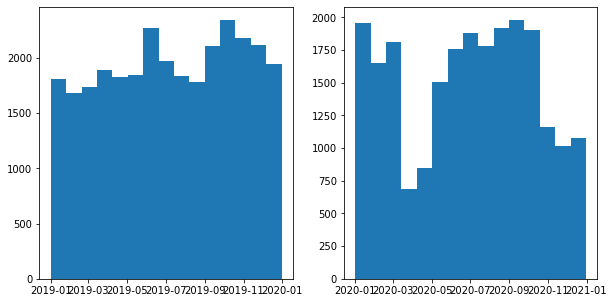

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(dateFormat19, bins=15)
axes[1].hist(dateFormat20, bins=15)

(array([18., 40., 59., 55., 60., 58., 48., 22.,  3.,  3.]),
 array([  6. ,  19.6,  33.2,  46.8,  60.4,  74. ,  87.6, 101.2, 114.8,
        128.4, 142. ]),
 <BarContainer object of 10 artists>)

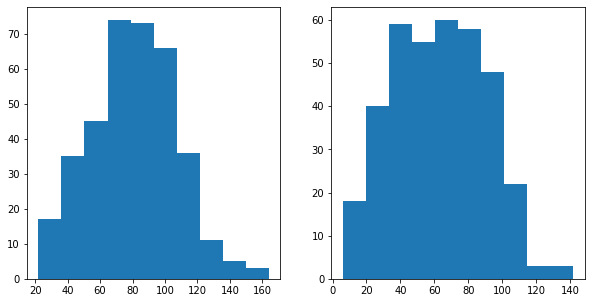

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(velikosti)
axes[1].hist(velikosti2)

### Vozniki ###

(array([  411.,  2757.,  9510., 10522., 10061.,  9171.,  5575.,  3115.,
         1114.,    59.]),
 array([ -1. ,   9.2,  19.4,  29.6,  39.8,  50. ,  60.2,  70.4,  80.6,
         90.8, 101. ]),
 <BarContainer object of 10 artists>)

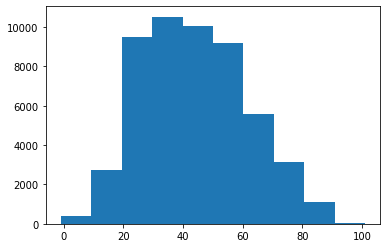

In [60]:
plt.hist(data["Starost"])

In [65]:
data["UraPN"].describe()

count     52295
unique     1271
top       16.00
freq        561
Name: UraPN, dtype: object

In [10]:
#plt.hist(data20["DatumPN"])

In [12]:
#datetime.strptime(data19["DatumPN"][0], "%d.%m.%Y")

In [13]:
#plt.plot(data19["DatumPN"])